Implementation of DenseUnet to segment Retina Blood Vessels

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 100
num_epochs = 200
lr = 1e-3
seed = 42
np.random.seed = seed

Loading the image and mask paths

In [4]:
train_path='Preprocessed/Train/Image'
train_mask_path='Preprocessed/Train/Mask'
test_path='Preprocessed/Test/Image'
test_mask_path='Preprocessed/Test/Mask'

X_train, Y_train = load_path(train_path, train_mask_path)
X_test, Y_test = load_path(test_path, test_mask_path)

Loading the image and masks to tensorflow dataset

In [5]:
Train = tf_data(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_data(X_test, Y_test, buffer_size, batch_size, num_epochs)

Displaying the train and test images and mask

In [ ]:
for x, y in Train:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();
    
for x, y in Test:
    f, plot = plt.subplots(1,2)
    plot[0].imshow(x[0])
    plot[1].imshow(y[0])
    plt.show();

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from Metrics import dice_coef, dice_loss, iou

In [7]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

In [8]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [9]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_densenet121_unet(input_shape):
    
    inputs = Input(input_shape)

    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)
#     densenet.trainable = False

    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    b1 = densenet.get_layer("pool4_relu").output

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

In [11]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

input_shape = (h, w, 3)
model = build_densenet121_unet(input_shape)
model.compile(optimizer=Adam(lr), loss=dice_loss, metrics=[dice_coef, iou, Accuracy(), Recall(), Precision()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [12]:
#Model Checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_retina', verbose = 1, save_best_only = True)

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=200, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = num_epochs, 
    callbacks=callbacks)

Epoch 1/200
 1/10 [==>...........................] - ETA: 0s - loss: 0.8700 - dice_coef: 0.1300 - iou: 0.0695 - accuracy: 0.0000e+00 - recall: 0.0603 - precision: 0.0869WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
10/10 [==============================] - 8s 835ms/step - loss: 0.7394 - dice_coef: 0.2711 - iou: 0.1596 - accuracy: 0.0000e+00 - recall: 0.5363 - precision: 0.2340 - val_loss: 0.8320 - val_dice_coef: 0.1682 - val_iou: 0.0918 - val_accuracy: 0.0000e+00 - val_recall: 0.9090 - val_precision: 0.1569
Epoch 2/200
10/10 [==============================] - 2s 225ms/step - loss: 0.5548 - dice_coef: 0.4516 - iou: 0.2924 - accuracy: 0.0000e+00 - recall: 0.7913 - precision: 0.4076 - val_loss: 0.8084 - val_dice_coef: 0.1905 - val_iou: 0.1053 - v

Epoch 25/200
10/10 [==============================] - 2s 228ms/step - loss: 0.1531 - dice_coef: 0.8506 - iou: 0.7404 - accuracy: 0.0030 - recall: 0.8425 - precision: 0.8844 - val_loss: 0.3116 - val_dice_coef: 0.6903 - val_iou: 0.5272 - val_accuracy: 6.8665e-06 - val_recall: 0.6021 - val_precision: 0.8846
Epoch 26/200
10/10 [==============================] - 3s 315ms/step - loss: 0.1455 - dice_coef: 0.8528 - iou: 0.7435 - accuracy: 0.0038 - recall: 0.8468 - precision: 0.8951 - val_loss: 0.3042 - val_dice_coef: 0.6976 - val_iou: 0.5356 - val_accuracy: 6.1035e-06 - val_recall: 0.6128 - val_precision: 0.8767
Epoch 27/200
10/10 [==============================] - 2s 228ms/step - loss: 0.1395 - dice_coef: 0.8596 - iou: 0.7539 - accuracy: 0.0043 - recall: 0.8457 - precision: 0.9069 - val_loss: 0.2665 - val_dice_coef: 0.7357 - val_iou: 0.5820 - val_accuracy: 4.8065e-05 - val_recall: 0.7135 - val_precision: 0.8048
Epoch 28/200
10/10 [==============================] - 2s 225ms/step - loss: 0.1406

10/10 [==============================] - 2s 226ms/step - loss: 0.1000 - dice_coef: 0.8984 - iou: 0.8157 - accuracy: 0.0189 - recall: 0.8783 - precision: 0.9363 - val_loss: 0.2454 - val_dice_coef: 0.7546 - val_iou: 0.6061 - val_accuracy: 0.0228 - val_recall: 0.7493 - val_precision: 0.7693
Epoch 53/200
10/10 [==============================] - 3s 282ms/step - loss: 0.0901 - dice_coef: 0.9100 - iou: 0.8349 - accuracy: 0.0195 - recall: 0.8895 - precision: 0.9445 - val_loss: 0.2441 - val_dice_coef: 0.7574 - val_iou: 0.6096 - val_accuracy: 0.0319 - val_recall: 0.7822 - val_precision: 0.7407
Epoch 54/200
10/10 [==============================] - 3s 265ms/step - loss: 0.0860 - dice_coef: 0.9109 - iou: 0.8367 - accuracy: 0.0200 - recall: 0.8942 - precision: 0.9480 - val_loss: 0.2408 - val_dice_coef: 0.7580 - val_iou: 0.6103 - val_accuracy: 0.0266 - val_recall: 0.7519 - val_precision: 0.7772
Epoch 55/200
10/10 [==============================] - 2s 227ms/step - loss: 0.0843 - dice_coef: 0.9130 - io

10/10 [==============================] - 2s 229ms/step - loss: 0.0656 - dice_coef: 0.9316 - iou: 0.8723 - accuracy: 0.0300 - recall: 0.9124 - precision: 0.9650 - val_loss: 0.2386 - val_dice_coef: 0.7635 - val_iou: 0.6176 - val_accuracy: 0.0327 - val_recall: 0.7200 - val_precision: 0.8135
Epoch 80/200
10/10 [==============================] - 2s 235ms/step - loss: 0.0657 - dice_coef: 0.9324 - iou: 0.8735 - accuracy: 0.0303 - recall: 0.9069 - precision: 0.9702 - val_loss: 0.2449 - val_dice_coef: 0.7569 - val_iou: 0.6089 - val_accuracy: 0.0386 - val_recall: 0.7810 - val_precision: 0.7357
Epoch 81/200
10/10 [==============================] - 2s 228ms/step - loss: 0.0623 - dice_coef: 0.9361 - iou: 0.8800 - accuracy: 0.0306 - recall: 0.9107 - precision: 0.9733 - val_loss: 0.2368 - val_dice_coef: 0.7657 - val_iou: 0.6205 - val_accuracy: 0.0357 - val_recall: 0.7525 - val_precision: 0.7784
Epoch 82/200
10/10 [==============================] - 2s 227ms/step - loss: 0.0605 - dice_coef: 0.9425 - io

10/10 [==============================] - 2s 230ms/step - loss: 0.0576 - dice_coef: 0.9390 - iou: 0.8854 - accuracy: 0.0372 - recall: 0.9148 - precision: 0.9772 - val_loss: 0.2363 - val_dice_coef: 0.7648 - val_iou: 0.6193 - val_accuracy: 0.0424 - val_recall: 0.7530 - val_precision: 0.7779
Epoch 107/200
10/10 [==============================] - 2s 227ms/step - loss: 0.0590 - dice_coef: 0.9393 - iou: 0.8858 - accuracy: 0.0373 - recall: 0.9111 - precision: 0.9775 - val_loss: 0.2427 - val_dice_coef: 0.7568 - val_iou: 0.6087 - val_accuracy: 0.0382 - val_recall: 0.7410 - val_precision: 0.7781
Epoch 108/200
10/10 [==============================] - 3s 263ms/step - loss: 0.0572 - dice_coef: 0.9454 - iou: 0.8966 - accuracy: 0.0377 - recall: 0.9174 - precision: 0.9745 - val_loss: 0.2386 - val_dice_coef: 0.7562 - val_iou: 0.6084 - val_accuracy: 0.0379 - val_recall: 0.7098 - val_precision: 0.8229
Epoch 109/200
10/10 [==============================] - 2s 238ms/step - loss: 0.0564 - dice_coef: 0.9415 -

10/10 [==============================] - 2s 231ms/step - loss: 0.0497 - dice_coef: 0.9484 - iou: 0.9019 - accuracy: 0.0434 - recall: 0.9245 - precision: 0.9809 - val_loss: 0.2380 - val_dice_coef: 0.7626 - val_iou: 0.6163 - val_accuracy: 0.0403 - val_recall: 0.7217 - val_precision: 0.8096
Epoch 134/200
10/10 [==============================] - 2s 236ms/step - loss: 0.0506 - dice_coef: 0.9487 - iou: 0.9025 - accuracy: 0.0438 - recall: 0.9239 - precision: 0.9796 - val_loss: 0.2358 - val_dice_coef: 0.7558 - val_iou: 0.6083 - val_accuracy: 0.0443 - val_recall: 0.7496 - val_precision: 0.7824
Epoch 135/200
10/10 [==============================] - 2s 228ms/step - loss: 0.0489 - dice_coef: 0.9530 - iou: 0.9104 - accuracy: 0.0440 - recall: 0.9264 - precision: 0.9808 - val_loss: 0.2403 - val_dice_coef: 0.7607 - val_iou: 0.6139 - val_accuracy: 0.0405 - val_recall: 0.7129 - val_precision: 0.8157
Epoch 136/200
10/10 [==============================] - 3s 306ms/step - loss: 0.0502 - dice_coef: 0.9468 -

10/10 [==============================] - 2s 232ms/step - loss: 0.0465 - dice_coef: 0.9521 - iou: 0.9087 - accuracy: 0.0478 - recall: 0.9263 - precision: 0.9844 - val_loss: 0.2370 - val_dice_coef: 0.7620 - val_iou: 0.6156 - val_accuracy: 0.0419 - val_recall: 0.7235 - val_precision: 0.8083
Epoch 161/200
10/10 [==============================] - 2s 232ms/step - loss: 0.0466 - dice_coef: 0.9544 - iou: 0.9129 - accuracy: 0.0490 - recall: 0.9297 - precision: 0.9810 - val_loss: 0.2488 - val_dice_coef: 0.7497 - val_iou: 0.5997 - val_accuracy: 0.0370 - val_recall: 0.6740 - val_precision: 0.8507
Epoch 162/200
10/10 [==============================] - 2s 232ms/step - loss: 0.0528 - dice_coef: 0.9424 - iou: 0.8915 - accuracy: 0.0478 - recall: 0.9211 - precision: 0.9788 - val_loss: 0.2492 - val_dice_coef: 0.7487 - val_iou: 0.5985 - val_accuracy: 0.0435 - val_recall: 0.7300 - val_precision: 0.7757
Epoch 163/200
10/10 [==============================] - 2s 235ms/step - loss: 0.0614 - dice_coef: 0.9361 -

10/10 [==============================] - 2s 230ms/step - loss: 0.0421 - dice_coef: 0.9586 - iou: 0.9206 - accuracy: 0.0519 - recall: 0.9317 - precision: 0.9875 - val_loss: 0.2342 - val_dice_coef: 0.7661 - val_iou: 0.6211 - val_accuracy: 0.0473 - val_recall: 0.7447 - val_precision: 0.7908
Epoch 188/200
10/10 [==============================] - 2s 231ms/step - loss: 0.0417 - dice_coef: 0.9577 - iou: 0.9190 - accuracy: 0.0526 - recall: 0.9328 - precision: 0.9870 - val_loss: 0.2360 - val_dice_coef: 0.7652 - val_iou: 0.6198 - val_accuracy: 0.0448 - val_recall: 0.7220 - val_precision: 0.8131
Epoch 189/200
10/10 [==============================] - 2s 230ms/step - loss: 0.0410 - dice_coef: 0.9591 - iou: 0.9214 - accuracy: 0.0515 - recall: 0.9322 - precision: 0.9894 - val_loss: 0.2346 - val_dice_coef: 0.7597 - val_iou: 0.6130 - val_accuracy: 0.0444 - val_recall: 0.7326 - val_precision: 0.8034
Epoch 190/200
10/10 [==============================] - 2s 228ms/step - loss: 0.0409 - dice_coef: 0.9573 -

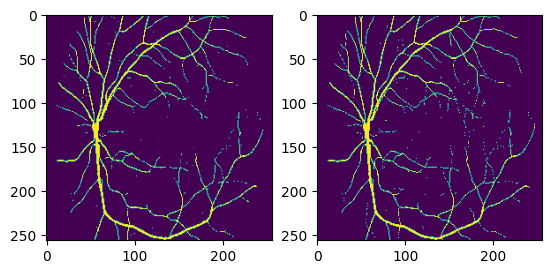

In [14]:
x, y = get_np_images(X_train, Y_train)
y_pred = model.predict(np.expand_dims(x[0], axis = 0))
# y_pred = y_pred > 0.5
# y_pred = y_pred.astype(np.int32)
f, plot = plt.subplots(1,2)
plot[0].imshow(y_pred[0])
plot[1].imshow(y[0])
plt.show();